In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm


In [2]:
df = pd.read_csv('parfume.csv').iloc[:, 2:]
df.head()

,id,age,group,vote
0,1,21,control,1
1,2,20,control,1
2,3,22,control,2
3,4,18,control,1
4,5,23,control,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      261 non-null    int64 
 1   age     261 non-null    int64 
 2   group   261 non-null    object
 3   vote    261 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 8.3+ KB


In [3]:
df = df[df.vote.isin([0,1])]
df.head()

,id,age,group,vote
0,1,21,control,1
1,2,20,control,1
3,4,18,control,1
4,5,23,control,0
5,6,18,control,1


In [4]:
control = df[df.group == 'control'][['vote']]
test = df[df.group == 'test'][['vote']]
control.head()

,vote
0,1
1,1
3,1
4,0
5,1


In [ ]:
test.head()

,vote
124,1
125,0
126,0
127,1
128,1


array([<AxesSubplot:title={'center':'vote'}>], dtype=object)

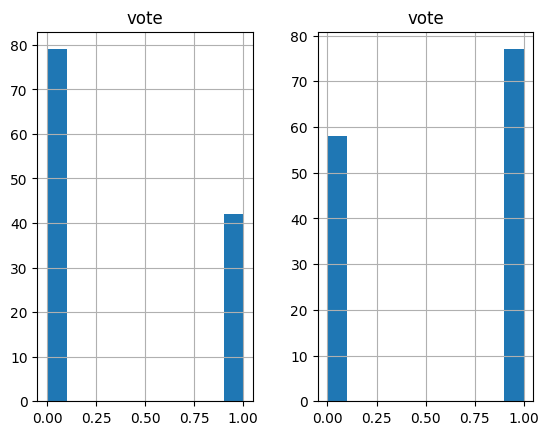

In [ ]:
_, ax = plt.subplots(1, 2)
ax = ax.flat
control.hist(ax=ax[0])
test.hist(ax=ax[1])

Посмотрим какая получилась мощность аб теста

In [5]:
dif = test.vote.mean() - control.vote.mean()
dif

0.22326293235384148

In [6]:
var0 = control.vote.mean() * (1 -control.vote.mean())
var1 = test.vote.mean() * (1 -test.vote.mean())
se = np.sqrt(var0 / control.vote.size + var1 / test.vote.size)
se

0.06072968756363913

In [7]:
cr = st.norm(loc=0, scale=se).ppf(0.95)
cr

0.09989144685268155

In [8]:
p1 = st.norm(loc=dif, scale=se).cdf(cr)
p2 = 1 - st.norm(loc=dif, scale=se).cdf(cr)
power = 1 - min(p1, p2)
power

0.9788971203497717

In [9]:
ratio = test.vote.size / control.vote.size
ratio

1.115702479338843

In [10]:
from statsmodels.stats.power import TTestIndPower
alpha = 0.05
dif_ = dif / se
analysis = TTestIndPower()
sample_size = analysis.solve_power(
    effect_size=dif_
    , nobs1=test.vote.size
    , alpha=alpha
    , power = None
    , ratio = ratio
    , alternative='larger'
)
sample_size

1.0

H0 - нет разницы в группах  
H1 - в тестовой группе доля девушек, кому понравился ролик выше

Проверим нулевую гипотезу с помощью бутстрепа

ConfidenceInterval(low=0.10441077441077484, high=0.34240587695133157)


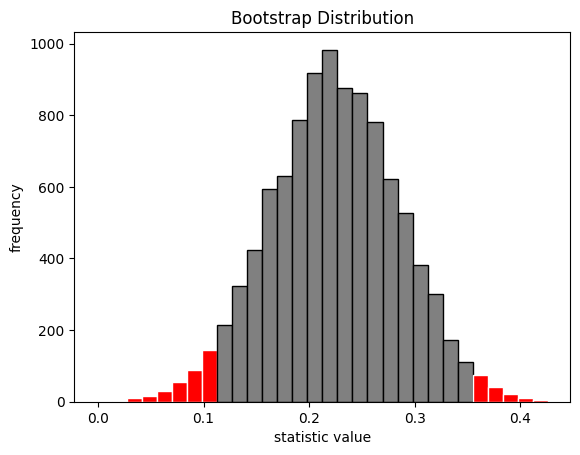

In [11]:
def my_statistic(sample1, sample2, axis=-1):
     return np.mean(sample1, axis=-1) - np.mean(sample2, axis=-1)
data = (test.vote.to_numpy(), control.vote.to_numpy())
res = st.bootstrap(data, my_statistic, method='basic', random_state=1)
print(res.confidence_interval)
fig, ax = plt.subplots()
_, _, bars = ax.hist(res.bootstrap_distribution, bins=30, ec='w')
for bar in bars:
    if bar.get_x() < res.confidence_interval[0] or bar.get_x() > res.confidence_interval[1]:
        bar.set_facecolor('red')
    else:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [12]:
boot_dist = res.bootstrap_distribution
p1 = st.norm(loc=np.mean(boot_dist), scale=np.std(boot_dist)).cdf(0)
p2 = st.norm(loc=-np.mean(boot_dist), scale=np.std(boot_dist)).cdf(0)
p_value = min(p1, p2) * 2
f'p-value = {p_value}'

'p-value = 0.00022669147432136973'

Проверим нулевую гипотезу с помощью т теста и теста мана уитни

In [ ]:
st.ttest_ind(test.vote.to_numpy(), control.vote.to_numpy())

Ttest_indResult(statistic=3.6541361589724093, pvalue=0.0003134787097274109)

In [ ]:
st.mannwhitneyu(test.vote.to_numpy(), control.vote.to_numpy())

MannwhitneyuResult(statistic=9991.0, pvalue=0.00036007100603094484)

Исходя из полученных данных можно сделать вывод, что на уровне значимости 0.05 есть основания отвергнуть нулевую гипотезу в пользу альтернативной